In [1]:
from brian2 import *
#import numpy as np
# from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

Excitatory Neurons:
$$ \tau_m^+ \frac{\phi^P(\vec r, t+\Delta t)  - \phi^p(\vec r, t)}{\Delta t} + \phi^P(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + \Sigma_{\vec r'}w^-(\vec r - \vec r')s^-(\vec r', t - \tau_s^-) + a^+(\vec r)[1 + \alpha E^P \bullet V(t)] + \zeta^P(\vec r, t)  $$

Inhibitory Neurons:
$$ \tau_m^+ \frac{\phi^-(\vec r, t+\Delta t)  - \phi^-(\vec r, t)}{\Delta t} + \phi^-(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + a^-(t) + \zeta^-(\vec r, t)  $$

Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

$$ a^+(\vec r) = \begin{cases}
                -a_{min}^+ + (a^+_{max} - a^+_{min})^{\frac{1 + cos(\pi \rho /\rho_{a^+})}{2}}& \text{; } \rho < \rho a+\\
                a_{min}^+          & \text{; } \rho \geq \rho a+.
         \end{cases}
                $$

$$ a^-(t) = a_{mag}^- - a_{th}^-cos(t\pi ft + \psi_0)  $$

$$ \rho = \frac{\sqrt{(x - \frac{n+1/2}{2}^2 + (y - \frac{n+1}{2}^2)}}{n/2} $$

In [2]:
start_scope() # creat a new scope

# Parameters
N = 232 * 232 # Neurons per population
N = 10 * 10

tau_m_plus = 40*ms # Exc. membrane time constant
tau_m_minus = 20*ms # Inh. membrane time constant
tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
tau_s_minus = 2*ms # Inh. synaptic delay
a_max_plus = 2 # Exc. drive maximum
a_min_plus = 0.8 # Exc. drive minimum
rho_a_plus = 1.2 # Exc. drive scaled speed
a_mag_minus = 0.72 # Inh. drive magnitude
a_th_minus = 0.2 # Inh. drive theta amplitude
f = 8*hertz # Inh. drive theta frequency
w_mag_plus = 0.2 # Exc. synaptic strength
r_w_plus = 6 # Exc. synaptic spread
w_mag_minus = 2.8 # Inh. synaptic strength
r_w_minus = 12 # Inh. synaptic distance
xi = 3 # Exc. synaptic shift
alpha = 0.25*second/metre # Exc. velocity gain
var_zeta_P = 0.002**2 # Exc. noise magnitude
var_zeta_I = 0.002**2 # Inh. noise magnitude


duration = 1000*ms


In [3]:
defaultclock.dt = 0.1*ms

### Velocity Inputs (Based on Rat Trajectory):
Two options:
1. Simulate the inputs (as done by Mittal & Narayanan, 2021)
2. Differentiate rat trajectories (as done by Burak & Fiete, 2009 and used in Kang & DeWeese 2019)


In [4]:
@implementation('numpy', discard_units=True)
@check_units(dir_x = metre, dir_y = metre, V_x = metre/second, V_y = metre/second, result= metre/second)
def dot_product(dir_x, dir_y, V_x, V_y):
    dir = [dir_x, dir_y]
    V = [V_x, V_y]
    product = dot(dir, V)
    print(product)
    return product * metre / second


In [5]:
dot_product(3 * metre, 2*metre, 1*metre/second, 5*metre/second)

13.0


13. * metre / second

In [6]:
eqns_exc_n = '''

x = i % sqrt(N) * metre : metre 
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = 1 * metre: metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1

'''

eqns_exc_s = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = -1 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)
 
a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_e = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_w = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = -1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''


""" 
eqns_exc = '''

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus/tau_m_plus : 1

'''  """

eqns_inh = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

dv/dt = -(v - a_minus)/tau_m_minus + var_zeta_I*xi*tau_m_minus**-0.5 : 1
a_minus = a_mag_minus - a_th_minus*cos(2*pi*f*t): 1

'''

reset = '''
v = 0
'''


In [7]:

#@check_units(i = 1, result = [metre for x in range(len(i))])
@check_units(i = 1, N = 1, result = metre)
def location_x(i, N):
    x = i % N
    return x * metre

@check_units(i = 1, N = 1, result = metre)
def location_y(i, N):
    y = i // N
    return y * metre

@implementation('numpy', discard_units=True)
@check_units(x = 1, y = 1, N = 1, result = metre)
def rho_value(x, y, N):

    value = sqrt(((x - ((N+1)/2))**2 + (y - ((N+1)/2))**2)/(N/2))

    return value * metre

""" @implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    value = a_min_plus * ones_like(rho)
    for i in range(len(rho)):
        if rho[i] < rho_a_plus:
            value[i] = (a_max_plus - a_min_plus) * (1 - cos(pi*rho[i]/rho_a_plus))
    return value """

@implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    if rho < rho_a_plus:
        value = (a_max_plus - a_min_plus) * (1 - cos(pi*rho/rho_a_plus))
    else:
        value = a_min_plus
    
    return value

@check_units(x = 1, y = 1, result = metre)
def dir_array(x, y, N):
    x_array = x * ones(N)
    y_array = y * ones(N)

    return column_stack((x_array, y_array)) * metre

In [8]:
# Neural Populations

## North
P_n = NeuronGroup(N, eqns_exc_n, threshold='v > 1', reset=reset, method='euler')
P_n.v = 'rand()'

## South
P_s = NeuronGroup(N, eqns_exc_s, threshold='v > 1', reset=reset, method='euler')
P_s.v = 'rand()'

## East
P_e = NeuronGroup(N, eqns_exc_e, threshold='v > 1', reset=reset, method='euler')
P_e.v = 'rand()'

## West
P_w = NeuronGroup(N, eqns_exc_w, threshold='v > 1', reset=reset, method='euler' )
P_w.v = 'rand()'

## Inhibitory
P_i = NeuronGroup(N, eqns_inh, threshold='v > 1', reset=reset, method='euler' )
P_i.v = 'rand()'

M_n = SpikeMonitor(P_n)
M_s = SpikeMonitor(P_s)
M_e = SpikeMonitor(P_e)
M_w = SpikeMonitor(P_w)



In [9]:
P_n.dir_x

<neurongroup.dir_x: 0. * metre>

In [10]:
for name, var in sorted(P_n.variables.items()):
    print('%s : %s' % (name, var))  

N : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_spikespace : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=False, read_only=False)>
a_plus : <ArrayVariable(dimensions=Dimension(),  dtype=float64, scalar=False, constant=False, read_only=False)>
dir_x : <Subexpression(name='dir_x', dimensions=metre, dtype=<class 'numpy.float64'>, expr='0 * metre', owner=<neurongroup>)>
dir_y : <Subexpression(name='dir_y', dimensions=metre, dtype=<class 'numpy.float64'>, expr='1 * metre', owner=<neurongroup>)>
dt : <ArrayVariable(dimensions=second,  dtype=float, scalar=True, constant=True, read_only=True)>
i : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
rho : <ArrayVariable(dimensions=metre,  dtype=float64, scalar=False, constant=False, read_only=False)>
t : <ArrayVariable(dimensions=second,  dtype=float64, scalar=True, constant=False, read_only=True)>
t_in_timesteps : <Ar

### Synaptic Connectivity Matrix
Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

In [11]:
def exc_to_any_connectivity(N, dir_x, dir_y, same_pop=False):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = empty((N, N))
   # dir = eval(dir) # convert string representation to list
    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N): # looping over target neurons
            j_x = j % N
            j_y = j % N
            
            if same_pop and i ==  j:
                connectivity[i, j] = 0
            else:
                connectivity[i, j] = w_mag_plus**(1 + cos(pi*sqrt((j_x - i_x - xi*dir_x)**2 + (j_y - i_y - xi*dir_y)**2)))

    return connectivity.flatten()


def inh_to_exc_connectivity(N):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = empty((N, N))

    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N):
            j_x = j % N
            j_y = j % N

            connectivity[i, j] = w_mag_minus**(1 + cos(pi*sqrt((j_x - i_x)**2 + (j_y - i_y)**2)))

    return connectivity.flatten()

In [12]:
S = [] # to store  the 25 synapse classes
exc_populations = [P_n, P_s, P_e, P_w]
all_populations = [P_n, P_s, P_e, P_w, P_i]
index = 0

# Set connections from excitatory to excitatory populations: (Total 16 iterations)
print("Setting up exc-->exc connections")
for src in exc_populations:
    print("Source po|pulation:", src.name)
    for trg in exc_populations:
        print("Target population:", trg)
        S.append(Synapses(src, trg, 'w: 1', on_pre='v_post += w'))
        if src == trg: # connection within the population     
            S[index].connect(condition='i!=j') # if connection within population, don't connect neurons to themselves
            # connectivity = exc_to_any_connectivity(N, src.dir, same_pop=True)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = delete(exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre, same_pop=True).flatten(), range(0, N*N, N+1), 0) # deletes diagonal entries of connectivity before assigning it to weights
        else:
            S[index].connect() # if connections are between two populations, connect all neurons
            # connectivity = exc_to_any_connectivity(N, src.dir)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
        S[index].delay = 'tau_s_plus_plus'
        index += 1

# Set connections from excitatory to inhibitory population: (Total 4 iterations)
print("Setting up exc-->inh connections")
for i in exc_populations:
    S.append(Synapses(i, P_i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = exc_to_any_connectivity(N, src.dir)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
    S[index].delay = 'tau_s_minus_plus'
    index += 1    

# Set connections from inhibitory to excitatory neurons: (Total 4 iterations)
print("Setting up inh-->exc connections")
for i in exc_populations:
    S.append(Synapses(P_i, i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = inh_to_exc_connectivity(N)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = inh_to_exc_connectivity(N).flatten()
    S[index].delay = 'tau_s_minus'
    index += 1

# The inhibitory population doesn't have recurrent connections within itself


Setting up exc-->exc connections
Source po|pulation: neurongroup
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')
Source po|pulation: neurongroup_1
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
Target populatio

### Simulation Protocol
* Each neuron initialised to a random potential between 0 & 1
* 500 timesteps without velocity input to generate grid like pattern
* 3 evolutions of timesteps with constant velocity input of 0.5m/sec at angles $\pi/2 - \pi/5, 2\pi/5, and \pi/4$ successively.
* Evolve the network for 4 laps without idle periods. (What is a lap?)

Where to get the velocity inputs from?

### Plot grid cell activity

Ways to do this:
1. Bin spiking activity in some time window and plot as heatmap on top of neural sheet (for any particular timewindow)
2. 

WARNING    /tmp/ipykernel_63137/3461522205.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
 [py.warnings]
WARNING    /tmp/ipykernel_63137/3461522205.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
 [py.warnings]


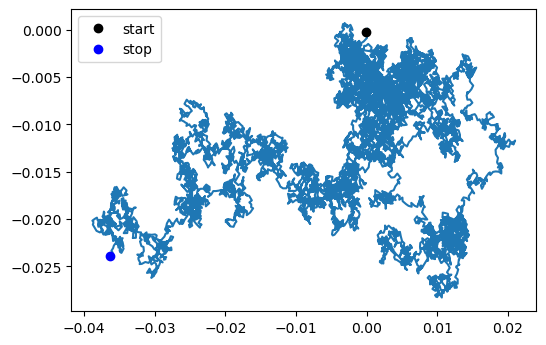

In [13]:
#@title Simulated Velocity Inputs:

def simulate_random_velocity(duration, dt, step_size):
    """
    Inputs
    
    """
    x = step_size * cumsum((random(int(duration/dt)) - 0.5))
    y = step_size * cumsum((random(int(duration/dt)) - 0.5))

    # velocity = column_stack((x, y))

    return x / second, y / second

step_size = 0.001*metre
dt = 0.1*ms
velocity_array_x, velocity_array_y = simulate_random_velocity(duration, dt, step_size)


figure(dpi=100)
plot(velocity_array_x[:], velocity_array_y[:])
plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
legend()



In [14]:
V_x = TimedArray(velocity_array_x, dt=dt)
V_y = TimedArray(velocity_array_y, dt=dt)

In [15]:
print(V_x(1*second))

-0.03629017 m/s


In [16]:
print("Running the simulation")
run(duration)

WARNING    "xi" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running the simulation


WARNING    "xi" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


0.0002379602477841477
-8.297354081222108e-05
8.297354081222108e-05
-0.0002379602477841477
-0.00012125150559681941
0.00015879154113157613
-0.00015879154113157613
0.00012125150559681941
0.000296171570418435
-0.0002417950194323777
0.0002417950194323777
-0.000296171570418435
0.0004278455656691821
0.00013434630013516157
-0.00013434630013516157
-0.0004278455656691821
0.0008192691762877786
3.2584042739686185e-05
-3.2584042739686185e-05
-0.0008192691762877786
0.0008586220394669177
5.432900279752573e-05
-5.432900279752573e-05
-0.0008586220394669177
0.0012275475699465444
-0.00039826913303409153
0.00039826913303409153
-0.0012275475699465444
0.0014513076665952467
-0.0008279383167441213
0.0008279383167441213
-0.0014513076665952467
0.0011770853505612443
-0.0010591744787922504
0.0010591744787922504
-0.0011770853505612443
0.0013862953285551176
-0.0013002376229430022
0.0013002376229430022
-0.0013862953285551176
0.0014800393388357392
-0.0008862087034639962
0.0008862087034639962
-0.0014800393388357392
0.

In [18]:
M_n.spike_trains()

{0: array([], dtype=float64) * second,
 1: array([], dtype=float64) * second,
 2: array([], dtype=float64) * second,
 3: array([], dtype=float64) * second,
 4: array([], dtype=float64) * second,
 5: array([], dtype=float64) * second,
 6: array([], dtype=float64) * second,
 7: array([], dtype=float64) * second,
 8: array([], dtype=float64) * second,
 9: array([], dtype=float64) * second,
 10: array([], dtype=float64) * second,
 11: array([], dtype=float64) * second,
 12: array([], dtype=float64) * second,
 13: array([], dtype=float64) * second,
 14: array([], dtype=float64) * second,
 15: array([], dtype=float64) * second,
 16: array([], dtype=float64) * second,
 17: array([], dtype=float64) * second,
 18: array([], dtype=float64) * second,
 19: array([], dtype=float64) * second,
 20: array([], dtype=float64) * second,
 21: array([], dtype=float64) * second,
 22: array([], dtype=float64) * second,
 23: array([], dtype=float64) * second,
 24: array([], dtype=float64) * second,
 25: array

## Plot Connectivity

S:
* 0 - 4 : north > north, south, east, west, inh
* 5 - 9 : south > north, south, east, west, inh
* 10 - 14: east > north, south, east, west, inh


In [ ]:


i = 0 # source neuron
print(S[1].w.shape)
connectivity = S[1].w[i*N : (i+1)*N]
print(connectivity.shape)
connectivity = connectivity.reshape(int(sqrt(N)), int(sqrt(N)))
imshow(connectivity.T)
print(connectivity)

In [ ]:
P_n.x

In [ ]:
P_n.y